# $$ \ Weighted Cross Entropy-based\ CatBoost \ Model \ for \ Imbalanced \ Classification$$

In [1]:
# 忽略warning
import warnings
warnings.filterwarnings("ignore")

import time
import scipy.stats as stats
import pandas as pd
import numpy as np
import pickle
import math

# 主题配置
import matplotlib  as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('seaborn-colorblind')
sns.set(context='notebook') #style='whitegrid' style控制默认样式,context控制着默认的画幅大小
sns.set(font_scale=1.2)
color = sns.color_palette() #seaborn自带色盘

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
import category_encoders as ce

# 导入自定义的工具函数
from utils.data_processing import normalize
from utils.metrics import *
from utils.feature_tools import FeatureTools
from utils.visualization import show_distribution,show_empty,plot_confusion_matrix

from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_recall_curve,auc,roc_curve,average_precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,StratifiedShuffleSplit
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb

<AxesSubplot:>

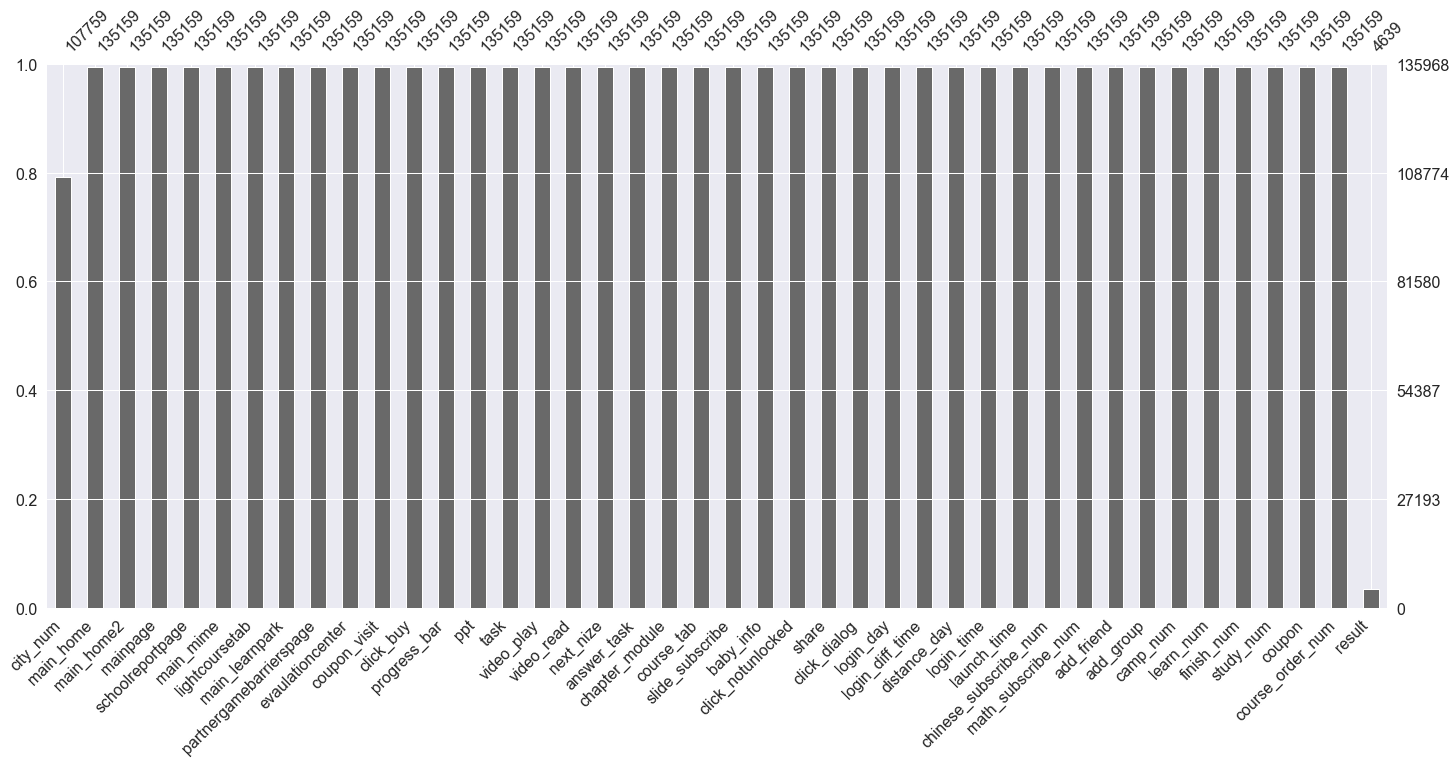

In [11]:
import missingno as msno
missing = df_all[empty_column]
msno.bar(missing)

<AxesSubplot:>

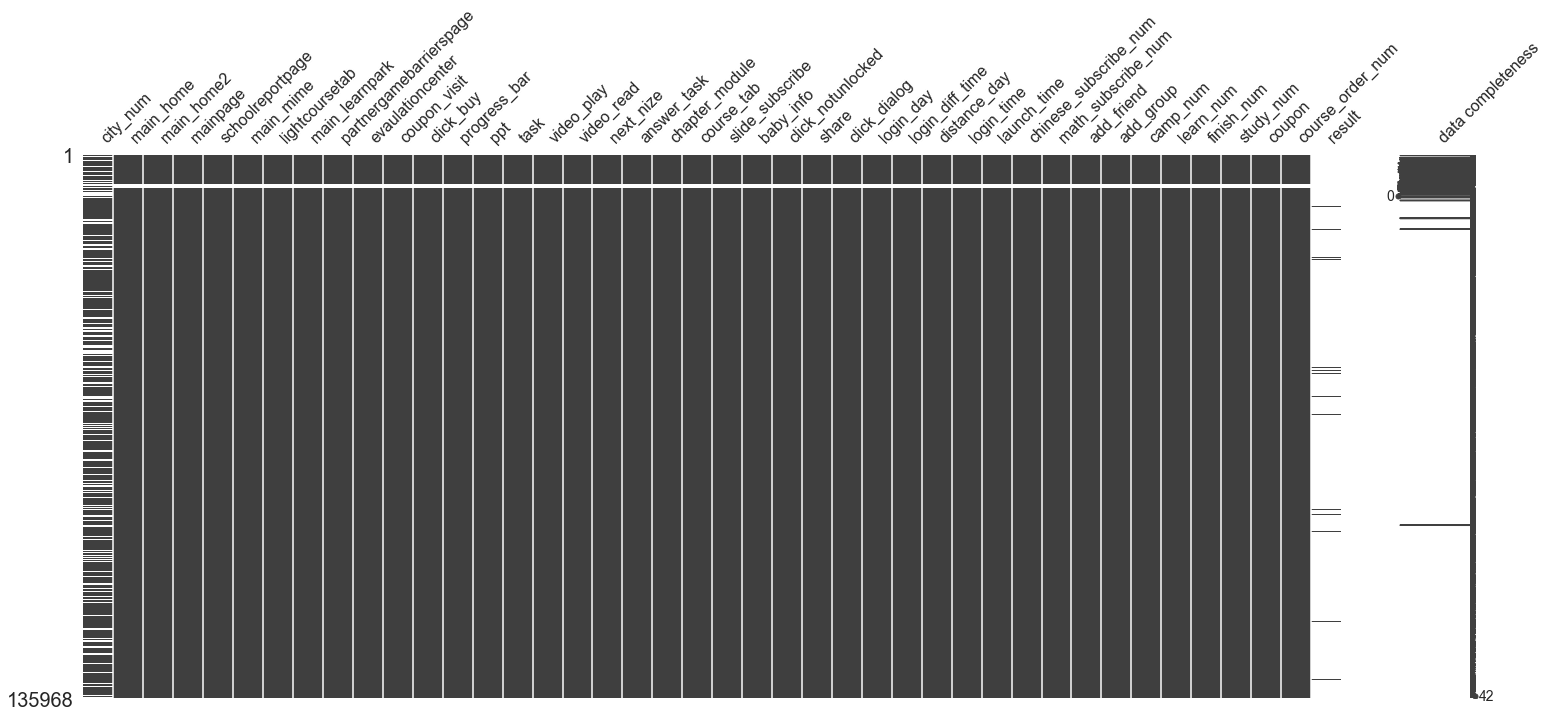

In [12]:
import missingno as msno
missing = df_all[empty_column]
msno.matrix(missing, labels=True)

## 从这里开始导入数据

In [6]:
df = pd.read_csv('./all_info_features.csv',encoding='utf-8')

## 特征编码

In [7]:
# 原始数据
# - df
# - x_data
# - y_labels

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import category_encoders as ce
# dir(ce)
SEED = 42
"""
# 准备数据
训练数据：去掉result标签、首单时间戳first_order_time、App激活app_num、月龄age_month
预测标签：result
"""
drop_cols = ['result','app_num','age_month','first_order_time']
x_data = df.drop(drop_cols,axis=1)
y_labels = df['result']
# y_names = [0,1]

"""
非数值类型（类别特征）：

独热编码：省份province
目标编码：城市city_num，设备model_num
序号编码：年龄段age_stage，首单体验课价位first_order_price_stage
# 交叉编码：平台和设备交叉、年龄段和首单体验课价位交叉
# catboost不平衡编码or均值编码：访问数？

数值类型放缩：z-score标准化
"""

""" 循环特征使用极坐标的角度来编码 """
cyclic_cols = ['first_order_hour','first_order_week','first_order_day', 'first_order_month','first_order_Q']
for col in cyclic_cols:
    x_data[col+'_SIN'] = np.sin((2 * np.pi * x_data[col])) / max(x_data[col])
    x_data[col+'_COS'] = np.cos((2 * np.pi * x_data[col])) / max(x_data[col])
x_data.drop(cyclic_cols, axis=1, inplace=True)

""" 独热编码 """
first_oder_cols = ['first_order_is_weekend','first_order_is_holiday', 'first_order_is_workday','first_order_is_free', 'first_order_is_under_ten']
is_list = ['chinese_subscribe_num','math_subscribe_num','add_friend','add_group','is_tier1_city','is_subscribe']
onehot_cols = first_oder_cols+is_list
x_data = ce.OneHotEncoder(cols = onehot_cols,drop_invariant= True).fit(x_data,y_labels).transform(x_data)

""" 序号编码 """
ordinal_cols = ['age_stage', 'first_order_price_stage']
x_data = ce.OrdinalEncoder(cols = ordinal_cols).fit(x_data,y_labels).transform(x_data)

""" RobustScaler标准化 """
visit_cols =['main_home', 'main_home2',
       'mainpage', 'schoolreportpage', 'main_mime', 'lightcoursetab',
       'main_learnpark', 'partnergamebarrierspage', 'evaulationcenter',
       'coupon_visit','progress_bar', 'ppt', 'task',
       'video_play', 'video_read', 'next_nize', 'answer_task',
       'chapter_module', 'course_tab', 'slide_subscribe', 'baby_info',
       'click_notunlocked', 'share', 'click_dialog','click_buy','visit_corr_weight_sum']
user_act_cols = ['age_year','coupon','first_order_duration','ADAU', 'AMAU', 'AWAU']
login_cols = ['login_day','login_diff_time','distance_day','login_time','launch_time']
study_cols = ['camp_num','learn_num','finish_num','study_num','finish_learn_ratio','daily_study_time']
cnt_colss = ['platform_num_cnt', 'model_num_cnt', 'city_num_cnt', 'province_cnt','age_stage_cnt', 'first_order_price_stage_stage_cnt']
# 数值放缩的列
scale_cols = visit_cols+user_act_cols+login_cols+study_cols+cnt_colss
x_data[scale_cols] = RobustScaler().fit_transform(x_data[scale_cols].values)
#[c for c in x_data.columns if c not in categorical_cols]

""" 目标编码 """
target_cols = ['city_num','model_num','platform_num','province','course_order_num']
x_data = ce.TargetEncoder(cols = target_cols,drop_invariant= True).fit(x_data,y_labels).transform(x_data)
print("编码完成！")
# # 交叉编码
# crossed_cols = (['coupon_visit', 'coupon'], ['next_nize', 'chinese_subscribe_num'],['platform_num','model_num'],['first_order_is_holiday','coupon_visit'])

# 标准化
# x_data[cnt_colss] = StandardScaler().fit_transform(x_data[cnt_colss].values)

# print(f"categorical_cols:{categorical_cols}\n\nscale_cols:{scale_cols}")
# preprocessor = FeatureTools()
# databunch = preprocessor(df, target_col='result', scale_cols=scale_cols,
#     scaler=RobustScaler(), categorical_cols=categorical_cols,cyclic_cols= x_cols=crossed_cols)
# pickle.dump(databunch, open('databunch.p', "wb"))


In [8]:
print(x_data)
"""
划分数据集 训练集9：测试集1
"""
from utils.split_dataset import imbalance_train_test_split
X_train, X_test, y_train, y_test = imbalance_train_test_split(x_data,y_labels,test_size=0.1,random_state=SEED)
id_train = X_train[:, 0]
X_train = X_train[:, 1:]
id_test = X_test[:, 0]
X_test = X_test[:, 1:]

print('训练集+验证集:%s, 测试集:%s'%(X_train.shape,X_test.shape))

def show_data_ratio(dfaux):
    print("不下单购买的占比: %1.4f (n=%d)"%(len(dfaux[dfaux == 0])/float(len(dfaux)),len(dfaux[dfaux == 0])))
    print("下单购买的占比: %1.4f (n=%d)"%(len(dfaux[dfaux == 1])/float(len(dfaux)),len(dfaux[dfaux == 1])))
    print("重采样数据总数: %d\n"%(len(dfaux)))

# 展示训练集数据占比
print("\n** 训练集+验证集 **")
show_data_ratio(y_train)
# 展示测试集数据占比
print("** 测试集 **")
show_data_ratio(y_test)

训练集+验证集:(121643, 100), 测试集:(13516, 100)

** 训练集+验证集 **
不下单购买的占比: 0.9657 (n=117468)
下单购买的占比: 0.0343 (n=4175)
重采样数据总数: 121643

** 测试集 **
不下单购买的占比: 0.9657 (n=13052)
下单购买的占比: 0.0343 (n=464)
重采样数据总数: 13516



封装训练评估函数

In [9]:
# 封装常用函数
def save_model(model, name):
    # 保存模型
    model.save_model(f"{name}")
    
def fit_CBM(model,resume_model=None,**fit_params):
    if resume_model:
        try: # 继续训练
            model.fit(**fit_params)
        except Exception as e:
            print(f"训练并保存一个新的模型{resume_model} / Error info:{e}")
            model.fit(**fit_params)
            save_model(model, resume_model)
    else: # 训练
        model.fit(**fit_params)
# 优化的评估指标
def eval_metrics_optimal(y_test,preds,metric):
    from utils.metrics import PRAUC, F1, GMean, MCC
    if metric is PRAUC:
        return PRAUC(y_test, preds)
    elif metics is F1:
        return F1(y_test, preds)
    elif metric is GMean:
        return Gmean(y_test, preds)
    elif metric is MCC:
        return MCC(y_test, preds)
    else:
        return metric(y_test, preds)

def eval(model,X_test,y_test,metrics_list):
    from catboost.utils import eval_metric
    probabilities = model.predict(X_test,'Probability')[:, 1] # 预测概率，获取正类的概率
    # sigmoid  = lambda x:1./(1. + np.exp(-x)) #对数几率函数
    # preds = list(map(sigmoid,probabilities))
    
    logit = lambda x:math.log(x/(1-x)) #对数几率函数 西瓜书P58
    preds = list(map(logit,probabilities))
    # preds = model.predict(X_test,prediction_type='Class')#[:, 1]

    scores ={}
    for metric in metrics_list:
        try:
            scores[f'{metric}'] = eval_metrics_optimal(y_test,preds,metric)
        except Exception as e:
            try:
                scores[f'{metric}'] = eval_metric(y_test,preds,metric)
            except:
                pass
    for k,v in scores.items():
        print(f"{k}:{v[0]}\n")

In [9]:
%%time
model_params = dict({
    'task_type': 'GPU',
    'devices':'0',
    'loss_function': 'Logloss',
    'eval_metric': ['F1', 'Precision', 'Recall','BalancedAccuracy','PRAUC','AUC','PRAUC:use_weights=false'][4], #过拟合检测或者最优模型选择的评估指标
    'custom_metric':['F1', 'Precision', 'Recall','BalancedAccuracy','PRAUC','AUC'], #自定义训练过程当中输出的评估指标,'PRAUC:use_weights=false'
    'auto_class_weights':'SqrtBalanced',
    'iterations': 800,
    'early_stopping_rounds': 100,
    'random_seed': 42,
    'boost_from_average': True,
    'boosting_type': 'Ordered',
    'depth': 9,'l2_leaf_reg': 4.282506487885507,'learning_rate': 0.498939586636504,'max_ctr_complexity': 6,
#     {'depth': 6,
#  'l2_leaf_reg': 7.601633313963571,
#  'learning_rate': 0.09865964789789183,
#  'max_ctr_complexity': 2}
# 'depth': 6, 'l2_leaf_reg': 7.601633313963571,'learning_rate': 0.09865964789789183,'max_ctr_complexity': 2,
    # 'rsm':0.8,
    # 'depth': 7, 'l2_leaf_reg': 10.158952355464557, 'learning_rate': 0.4601540416991584,
    'name':'CatBoost_DSA', #在可视化工具当中需要显示的实验名字
    'train_dir':r'E:\myProjects\DSA\models\train_dir', #训练过程当中文件保存的目录
})
# {'depth': 5,'l2_leaf_reg': 8.0107012596694,'learning_rate': 0.1568783156149514, 'max_ctr_complexity': 3}
# 定义模型
model_cb = CatBoostClassifier(**model_params)

# 准备池
train_pool = Pool(X_train,y_train)
test_pool = Pool(X_test,y_test)
# 训练模型
fit_params = dict({
    'X':train_pool,
    # 'eval_set':valid_pool,
    'verbose':50,
    'plot':False, #设置可视化则不输出过程
    # 'use_best_model':True, #使用最优模型
})
fit_CBM(model_cb,resume_model=None,**fit_params)
# save_model(model_cb, f"final_WCE_CBM_{}.model")

NameError: name 'X_train' is not defined

## 模型评估

In [11]:
# 'depth': 9,'l2_leaf_reg': 4.282506487885507,'learning_rate': 0.498939586636504,'max_ctr_complexity': 6,
# GPU版本final
model_cb.get_best_score()

{'learn': {'Recall:use_weights=false': 0.9928143712574851,
  'Precision:use_weights=false': 0.9398820326678766,
  'PRAUC:use_weights=true': 0.9992051527224195,
  'PRAUC': 0.9992051527224195,
  'AUC': 0.999848484992981,
  'Logloss': 0.013745768874359701,
  'BalancedAccuracy:use_weights=true': 0.995249423514805,
  'Precision:use_weights=true': 0.9880850092009882,
  'Recall:use_weights=true': 0.9928143712574851,
  'PRAUC:use_weights=false': 0.9963397096217728,
  'BalancedAccuracy:use_weights=false': 0.995249423514805,
  'F1:use_weights=true': 0.9903039595603461,
  'F1:use_weights=false': 0.9654047757716948}}

In [77]:
# GPU 版本2
# 评估
metrics_list = ['F1', 'Accuracy','Precision', 'Recall','BalancedAccuracy','PRAUC','AUC','GMean','MCC','ROCAUC']
eval(model_cb,X_test,y_test,metrics_list)

F1:0.8704663212435233

Accuracy:0.9907517016868896

Precision:0.8383233532934131

Recall:0.9051724137931034

BalancedAccuracy:0.949483234172065

PRAUC:0.9402398378326464

AUC:0.9935402620288079

MCC:0.866363339028144



In [12]:
# GPU 版本final
# 评估
metrics_list = ['F1', 'Accuracy','Precision', 'Recall','BalancedAccuracy','PRAUC','AUC','GMean','MCC','ROCAUC']
eval(model_cb,X_test,y_test,metrics_list)

In [56]:
save_model(model_cb,'Final_Weighted_CE_CB_PRC9458_AUC9951_F18677_.model')

In [78]:
model_cb2 = CatBoostClassifier()
model_cb2.load_model(r'E:\myProjects\DSA\Final_Weighted_CE_CB_PRC9458_AUC9951_F18677_.model')


In [79]:
# 本地加载版本 评估
metrics_list = ['F1', 'Accuracy','Precision', 'Recall','BalancedAccuracy','PRAUC','AUC','MCC']
eval(model_cb2,X_test,y_test,metrics_list)

F1:0.8704663212435233

Accuracy:0.9907517016868896

Precision:0.8383233532934131

Recall:0.9051724137931034

BalancedAccuracy:0.949483234172065

PRAUC:0.9402398378326464

AUC:0.9935402620288079

MCC:0.866363339028144



In [107]:
from utils.split_dataset import imbalance_train_test_split
X_train, X_test, id_train, id_test = train_test_split(x_data,x_data.index,test_size=0.1,random_state=SEED,stratify=y_labels)

Int64Index([ 34042,  98737, 115740,  73905, 109462,  24379,  71194, 112360,
            114760,  94343,
            ...
            128157,  53044, 108140, 115074,  72760,  80674,  50470, 100407,
             13085,   4502],
           dtype='int64', length=121643)

In [16]:
test_predictions = np.zeros(X_test.shape[0])
probabilities = model_cb.predict(X_test,'Probability')[:, 1] # 预测概率，获取正类的概率
sigmoid  = lambda x:1./(1. + np.exp(-x)) #对数几率函数
preds_sigmoid = list(map(sigmoid,probabilities))
logit = lambda x:math.log(x/(1-x)) #对数几率函数 西瓜书P58
preds_logit = list(map(logit,probabilities))

test_predictions = model_cb.predict(X_test,prediction_type='Class')#[:, 1]
# preds = preds_logit
# print(model_cb.predict(X_test))
# print(id_test)
submission = pd.DataFrame({'user_id': id_test, 'result': test_predictions})
submission.to_csv("test_result.csv",index=False)
# metrics_list = ['F1', 'Accuracy','Precision', 'Recall','BalancedAccuracy','PRAUC','AUC','MCC']
# scores={}
# for m in metrics_list:
#     scores[m]=eval_metric(y_test,preds,m)

# for k,v in scores.items():
#     print(f"{k}:{v}")
# eval(model_cb2,X_test,y_test,metrics_list)

In [60]:
# df.user_id
# x_data.user_id
# y_labels
# X_test.shape
# y_test.shape
# X_test.user_id
test_predictions = np.zeros(X_test.shape[0])
probabilities = model_cb.predict(X_test,'Probability')[:, 1] # 预测概率，获取正类的概率
sigmoid  = lambda x:1./(1. + np.exp(-x)) #对数几率函数
preds_sigmoid = list(map(sigmoid,probabilities))
logit = lambda x:math.log(x/(1-x)) #对数几率函数 西瓜书P58
preds_logit = list(map(logit,probabilities))
# pred = model_cb.predict(X_test,prediction_type='Class')#[:, 1]
preds = preds_sigmoid
from catboost.utils import eval_metric
scores ={}
for metric in metrics_list:
    scores[f'{metric}'] = eval_metric(y_test,preds,metric)
for k,v in scores.items():
    print(f"{k}:{v[0]}\n")
# test_predictions = model_cb.predict(X_test)
# test_predictions = df['X_test']

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/loss_description.cpp:17: GMean loss is not supported

In [ ]:
submission = pd.DataFrame({'user_id': test_ids, 'result': test_predictions})

## 可解释性

In [61]:
import catboost
from catboost import *
import shap
shap.initjs() 

In [69]:
# x_data = df.drop(drop_cols,axis=1)
# y_labels = df['result']
shap_values = model_cb.get_feature_importance(Pool(x_data, y_labels), type='ShapValues')

In [73]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

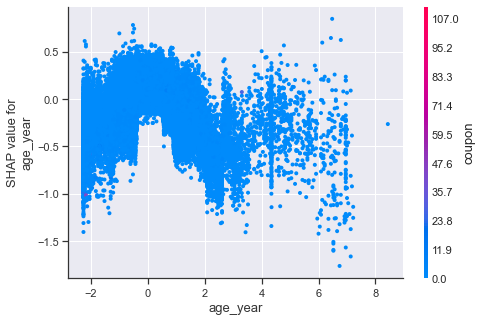

In [74]:
shap.dependence_plot("distance_day", shap_values, x_data)

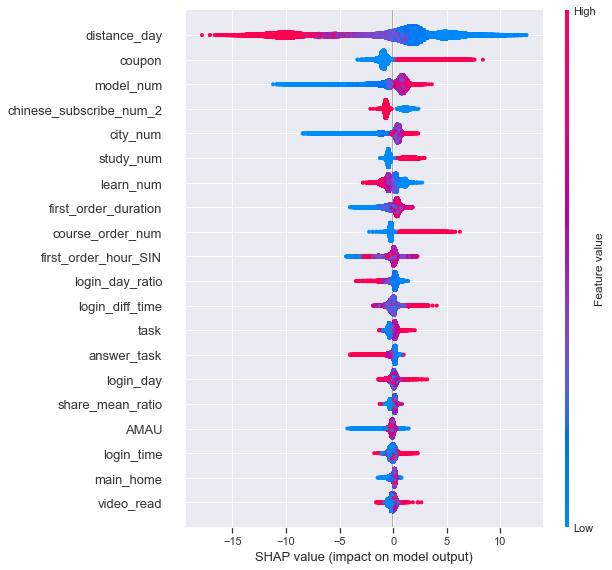

In [75]:
shap.summary_plot(shap_values, x_data)

In [76]:
model_cb.plot_tree(
    tree_idx=0,
    pool=pool # "pool" is required parameter for trees with one hot features
)

<Figure size 432x288 with 0 Axes>